In [1]:
%matplotlib inline
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from proteus.visu import matrix as visu
from proteus.matrix import tseries as ts
import nibabel as nib
from nibabel.affines import apply_affine
import pandas as pd
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression
from nilearn.masking import compute_epi_mask

from proteus.matrix import registration
reload(registration)

/home/cdansereau/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<module 'proteus.matrix.registration' from '/home/cdansereau/git/Proteus/proteus/matrix/registration.pyc'>

# Load data low motion
we load the data depending on the source HC0040123, SZ0040142 and SZ0040084

In [2]:
subj_id='HC0040123'
# original subject from pierre exp
covar = pd.read_csv('/home/cdansereau/data/deepmotion/cobre/xp_2016_07_27_final/fmri_'+subj_id+'_session1_run1_n_confounds.tsv.gz',sep='\t')
covar.columns
vol_nii = nib.load('/home/cdansereau/data/deepmotion/cobre/xp_2016_07_27_final/rest_'+subj_id+'.nii.gz')


We extract the functional volume and relevant covariates (slow time drift and motion params)

In [3]:
vol = vol_nii.get_data()
Xmotion = covar.iloc[:,0:6].values
Xdrift  = covar.iloc[:,8:14].values
fd = covar['FD'].values

# Extract mask

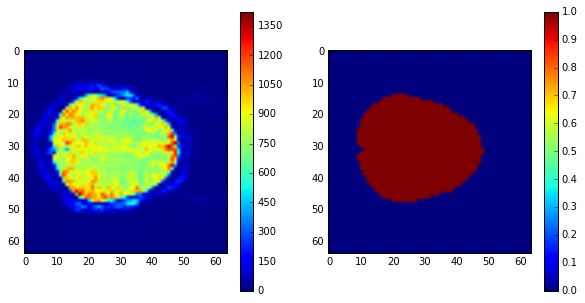

In [4]:
# compute the functional mask for the subject
mask_b = compute_epi_mask(vol_nii).get_data().astype(bool)
mask = vol[...,0]>-10000

# show functional 
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(vol.mean(3)[:,:,20])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(mask_b[:,:,20],clim=(0.0, 1.))
plt.colorbar()

Create some functional to help with the visualization

In [5]:
# R2 score
def getR2(y,ypred,mask=[]):
    if mask==[]:
        R2 = 1. - np.sum((y-ypred)**2,0)/np.sum(y**2,0)
    else:   
        R2 = 1. - np.sum((y[:,mask]-ypred[:,mask])**2,0)/np.sum(y[:,mask]**2,0)
    return R2

def getMap(val,mask):
    if len(val.shape)==2:
        new_map = np.zeros((mask.shape[0],mask.shape[1],mask.shape[2],val.shape[1])).astype(float)
    else:
        new_map = np.zeros_like(mask).astype(float)
    new_map[mask] = val
    return new_map

def getspec(vol):
    nx,ny,nz = vol.shape
    nrows = int(np.ceil(np.sqrt(nz)))
    ncolumns = int(np.ceil(nz/(1.*nrows)))
    return nrows,ncolumns,nx,ny,nz

def montage(vol1):

    vol = np.swapaxes(vol1,0,1)
    nrows,ncolumns,nx,ny,nz = getspec(vol)

    mozaic = np.zeros((nrows*nx,ncolumns*ny))
    indx,indy = np.where(np.ones((nrows,ncolumns)))

    for ii in np.arange(vol.shape[2]):
        # we need to flip the image in the x axis
        mozaic[(indx[ii]*nx):((indx[ii]+1)*nx),(indy[ii]*ny):((indy[ii]+1)*ny)] = vol[::-1,:,ii]

    return mozaic

In [6]:
cut_idx = 20
def show_diff(ref_vals,pred_vals,mask,frame=10,cut=cut_idx):
    plt.figure(figsize=(15,5))
    ref_vol = getMap(ref_vals[frame,:],mask)
    lim_val = [ref_vol[:,:,cut].min(),ref_vol[:,:,cut].max()]
    plt.subplot(1,3,1)
    visu.mat(getMap(ref_vals[frame,:],mask)[:,:,cut],lim=lim_val)
    plt.subplot(1,3,2)
    visu.mat(getMap(pred_vals[frame,:],mask)[:,:,cut],lim=lim_val)
    plt.subplot(1,3,3)
    visu.mat(getMap((ref_vals-pred_vals)[frame,:],mask)[:,:,cut],lim=lim_val)
    
def show_report(ref_vals,pred_vals,mask,frames,mask_b=[],cut=cut_idx):
    n_frames = len(frames)
    # R2
    if mask_b ==[]:
        R2 = getR2(ref_vals,pred_vals)

        fig=plt.figure(figsize=(15,5+5*len(frames)))
        ax = plt.subplot(n_frames+1,2,1)
        plt.title('R2 Mean:'+str(round(R2.mean(),3))+' Min:'+str(round(R2.min(),3))+' Max:'+str(round(R2.max(),3)))
        visu.mat(getMap(R2,mask)[:,:,cut],lim=[-1,1])
        plt.subplot(n_frames+1,2,2)
        plt.title('R2 distribution')
        plt.hist(R2,100)
    else:
        R2 = getR2(ref_vals[:,mask_b[mask]],pred_vals[:,mask_b[mask]])

        fig=plt.figure(figsize=(15,5+5*len(frames)))
        ax = plt.subplot(n_frames+1,2,1)
        plt.title('R2 Mean:'+str(round(R2.mean(),3))+' Min:'+str(round(R2.min(),3))+' Max:'+str(round(R2.max(),3)))
        visu.mat(getMap(R2,mask_b)[:,:,cut],lim=[-1,1])
        plt.subplot(n_frames+1,2,2)
        plt.title('R2 distribution')
        plt.hist(R2,100)
    
    # frames
    for ii in range(n_frames):
        ref_vol = getMap(ref_vals[frames[ii],:],mask)
        lim_val = [ref_vol[:,:,cut].min(),ref_vol[:,:,cut].max()]
        plt.subplot(n_frames+1,3,3+3*ii+1)
        visu.mat(getMap(ref_vals[frames[ii],:],mask)[:,:,cut],lim=lim_val)
        if ii == 0: plt.title('Reference')
        plt.ylabel('Frame '+str(frames[ii]))
        plt.subplot(n_frames+1,3,3+3*ii+2)
        visu.mat(getMap(pred_vals[frames[ii],:],mask)[:,:,cut],lim=lim_val)
        if ii == 0: plt.title('Prediction')
        plt.subplot(n_frames+1,3,3+3*ii+3)
        visu.mat(getMap((ref_vals-pred_vals)[frames[ii],:],mask)[:,:,cut],lim=lim_val)
        if ii == 0: plt.title('Difference')
    
def show_report_od(ref_vals,pred_vals,mask,frames,cut=cut_idx):
    n_frames = len(frames)
    fig=plt.figure(figsize=(15,5*len(frames)))
    # frames
    for ii in range(n_frames):
        ref_vol = getMap(ref_vals[frames[ii],:],mask)
        lim_val = [ref_vol[:,:,cut].min(),ref_vol[:,:,cut].max()]
        plt.subplot(n_frames+1,3,3+3*ii+1)
        visu.mat(getMap(ref_vals[frames[ii],:],mask)[:,:,cut],lim=lim_val)
        if ii == 0: plt.title('Reference')
        plt.ylabel('Frame '+str(frames[ii]))
        plt.subplot(n_frames+1,3,3+3*ii+2)
        visu.mat(getMap(pred_vals[frames[ii],:],mask)[:,:,cut],lim=lim_val)
        if ii == 0: plt.title('Prediction')
        plt.subplot(n_frames+1,3,3+3*ii+3)
        visu.mat(getMap((ref_vals-pred_vals)[frames[ii],:],mask)[:,:,cut],lim=lim_val)
        if ii == 0: plt.title('Difference')
    
def vol2vec(vol):
    mask = vol<inf
    return vol[mask],mask

def vec2vol(vec,mask):
    new_vol = np.zeros_like(mask)
    new_vol[mask] = vec
    return new_vol
    
    

# Convolutional model

## mask outside the brain to be at zeros
## normalization of the input image
###in a range 0 to 1
### center the robust median to zero (see old work on deppmotion)

In [7]:
import theano
import theano.tensor as T

def mean_squared_error_masked(y_true, y_pred):
    return T.mean(T.mean(T.mean(T.square(y_pred - y_true), axis=-1), axis=-1), axis=-1)


Using gpu device 0: GeForce GTX 550 Ti (CNMeM is disabled, cuDNN not available)


Using Theano backend.
Using gpu device 0: GeForce GTX 550 Ti (CNMeM is disabled, cuDNN not available)

--------------------kfold 1--------------------
(None, 135168, 32)
(None, 32, 64, 64, 33)
(None, 135168, 32)
(None, 1, 64, 64, 33)
Train on 108 samples, validate on 27 samples
Epoch 1/1
108/108 [==============================] - 104s - loss: 0.1589 - val_loss: 0.1467
Average R2:  -1.65739370327


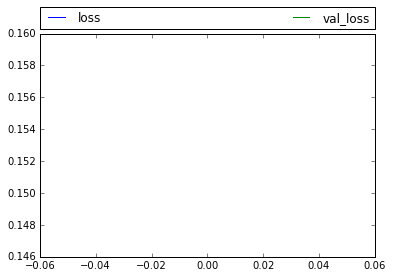

In [7]:
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.layers.convolutional import Convolution3D
from keras.layers.convolutional import UpSampling3D
from keras.engine.topology import Merge
from keras.layers.core import RepeatVector,Reshape
from keras.regularizers import l2, activity_l2
#from keras.layers.core import SpatialDropout3D


def build_model(output_size,kdim=[3,3,3],motion_out_size=32):
    
    # motion branch
    model_motion = Sequential()
    model_motion.add(Dense(32,input_dim=6,init='uniform',W_regularizer=None))
    model_motion.add(Activation('tanh'))
    model_motion.add(Dropout(0.5))
    
    #model_motion.add(Dense(32,init='uniform',W_regularizer=None))
    #model_motion.add(Activation('tanh'))
    #model_motion.add(Dropout(0.5))
    
    model_motion.add(Dense(motion_out_size,init='uniform',W_regularizer=None))
    model_motion.add(Activation('tanh'))
    #model_motion.add(Dropout(0.5))
        
    model_motion.add(RepeatVector(output_size[0]*output_size[1]*output_size[2]))
    
    print model_motion.output_shape
        
    # convolution branch
    model_conv = Sequential()
    #model.add(UpSampling3D(size=(2, 2, 2), dim_ordering='default',input_shape=(1, output_size[0], output_size[1], output_size[2])))
    model_conv.add(Convolution3D(32,kernel_dim1=kdim[0],kernel_dim2=kdim[1],kernel_dim3=kdim[2], input_shape=(1, output_size[0], output_size[1], output_size[2]),border_mode='same',W_regularizer=None,init='uniform'))
    model_conv.add(Activation('tanh'))
    #model_conv.add(SpatialDropout3D(0.5))
    
    #model_conv.add(Convolution3D(32,kernel_dim1=kdim[0],kernel_dim2=kdim[1],kernel_dim3=kdim[2],border_mode='same',W_regularizer=None,init='uniform'))
    #model_conv.add(Activation('tanh'))
    #model_conv.add(SpatialDropout3D(0.5))
    
    #model_conv.add(Convolution3D(32,kernel_dim1=kdim[0],kernel_dim2=kdim[1],kernel_dim3=kdim[2],border_mode='same',init='uniform'))
    #model_conv.add(Activation('tanh'))
    #model_conv.add(SpatialDropout3D(0.5))

    model_conv.add(Convolution3D(motion_out_size,kernel_dim1=kdim[0],kernel_dim2=kdim[1],kernel_dim3=kdim[2],border_mode='same',W_regularizer=None,init='uniform'))
    model_conv.add(Activation('tanh'))
    
    print model_conv.output_shape
    model_conv.add(Reshape((output_size[0]*output_size[1]*output_size[2],motion_out_size)))
    
    print model_conv.output_shape
    
    merged_model = Sequential()
    merged_model.add(Merge([model_motion, model_conv], mode='mul'))
    
    merged_model.add(Reshape((motion_out_size,output_size[0],output_size[1],output_size[2])))
    
    merged_model.add(Convolution3D(32,kernel_dim1=kdim[0],kernel_dim2=kdim[1],kernel_dim3=kdim[2],border_mode='same',W_regularizer=None,init='uniform'))
    merged_model.add(Activation('tanh'))
    merged_model.add(Convolution3D(32,kernel_dim1=kdim[0],kernel_dim2=kdim[1],kernel_dim3=kdim[2],border_mode='same',W_regularizer=None,init='uniform'))
    merged_model.add(Activation('tanh'))
        
    merged_model.add(Convolution3D(1,kernel_dim1=kdim[0],kernel_dim2=kdim[1],kernel_dim3=kdim[2],border_mode='same',init='uniform'))
    merged_model.add(Activation('linear'))
    
    print merged_model.output_shape
    
    #addavg_model = Sequential()
    #addavg_model.add(Merge([merged_model, model_conv.layers[0]], mode='sum'))
    
    
    

    sgd = SGD(lr=.1, decay=1e-5, momentum=0.5, nesterov=False)
    merged_model.compile(loss='mean_squared_error', optimizer=sgd)
    #merged_model.compile(loss=mean_squared_error_masked, optimizer=sgd) #compute the loss inside the brain only
    return merged_model


nb_epoch = 1
validation_split = 0.2

# put the outside of the brain to zero
vol[~mask_b]=0


ts = vol[mask].T
kf = KFold(n=ts.shape[0], n_folds=10, shuffle=False,random_state=None)

pred_vals = []
ref_vals = []
k=1
for train, test in kf:
    
    ssx = MinMaxScaler(feature_range=(-1,1))
    ssy = MinMaxScaler(feature_range=(-1,1))
    ssvol = MinMaxScaler(feature_range=(0,1))
    
    #print train
    print ('-'*20)+'kfold '+ str(k)+('-'*20)
    k+=1
     # Train
    lreg_d = LinearRegression(fit_intercept=True,normalize=False)
    lreg_d.fit(Xdrift[train,:],ts[train,:])
    new_ts = ts-lreg_d.predict(Xdrift)
    
    lreg_md = LinearRegression(fit_intercept=True,normalize=False)
    lreg_md.fit(Xdrift[train,:],Xmotion[train,:])
    new_Xmotion = Xmotion - lreg_md.predict(Xdrift)
                     
    mean_volume = ssvol.fit_transform(lreg_d.intercept_.reshape(-1, 1))
    mean_volume = mean_volume.reshape((vol[...,0].shape))[np.newaxis,np.newaxis,...]
    y_ = ssy.fit_transform(new_ts[train,:]).reshape((len(train),vol.shape[0],vol.shape[1],vol.shape[2]))[:,np.newaxis,...]
    
    # Learn the regression parameters to predict time series
    model = build_model(vol.shape[:3])
    
    #model.lr=10
    #model.momentum=0.5
    x_augm,y_augm = [ssx.fit_transform(new_Xmotion[train,:]),np.concatenate((mean_volume,)* len(train), axis=0)],y_
    #x_augm,y_augm = data_augm(ssx.fit_transform(new_Xmotion[train,:]),np.concatenate((mean_volume,)* len(train), axis=0),y_)
    
    
    hist = model.fit(x_augm, y_augm,verbose=1, nb_epoch=nb_epoch, batch_size=1,validation_split=validation_split)
    
    plt.figure()
    if validation_split == 0.:
        plt.plot(range(nb_epoch),hist.history['loss'])
    else:
        plt.plot(range(nb_epoch),hist.history['loss'],range(nb_epoch),hist.history['val_loss'])
    plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    
    ## Test on independent data
    X_test = ssx.transform(new_Xmotion[test,:])
    mean_volumes_ = np.concatenate((mean_volume,)* len(test), axis=0)
    test_data = model.predict([X_test,mean_volumes_],batch_size=1)
    
    test_denorm = ssy.inverse_transform(test_data.reshape((len(test),vol.shape[0]*vol.shape[1]*vol.shape[2])))
    pred_vals.append(test_denorm)
    #.reshape((vol[...,test].shape))
    ref_vals.append(new_ts[test,:])
    
    break
    
print 'Average R2: ',getR2(np.vstack(ref_vals),np.vstack(pred_vals),mask=mask_b[mask]).mean()

In [7]:
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.layers.convolutional import Convolution3D
from keras.layers.convolutional import UpSampling3D
from keras.engine.topology import Merge
from keras.layers.core import RepeatVector,Reshape
from keras.regularizers import l2, activity_l2
#from keras.layers.core import SpatialDropout3D


def build_model(output_size,kdim=[3,3,3],motion_out_size=32):
    
        
    # convolution branch
    model_conv = Sequential()
    #model.add(UpSampling3D(size=(2, 2, 2), dim_ordering='default',input_shape=(1, output_size[0], output_size[1], output_size[2])))
    model_conv.add(Convolution3D(80,kernel_dim1=kdim[0],kernel_dim2=kdim[1],kernel_dim3=kdim[2], input_shape=(6, output_size[0], output_size[1], output_size[2]),border_mode='same',W_regularizer=None,init='uniform'))
    model_conv.add(Activation('tanh'))
    #model_conv.add(SpatialDropout3D(0.5))
    
    #model_conv.add(Convolution3D(32,kernel_dim1=kdim[0],kernel_dim2=kdim[1],kernel_dim3=kdim[2],border_mode='same',W_regularizer=None,init='uniform'))
    #model_conv.add(Activation('tanh'))
    #model_conv.add(SpatialDropout3D(0.5))
    
    #model_conv.add(Convolution3D(32,kernel_dim1=kdim[0],kernel_dim2=kdim[1],kernel_dim3=kdim[2],border_mode='same',init='uniform'))
    #model_conv.add(Activation('tanh'))
    #model_conv.add(SpatialDropout3D(0.5))

    
    model_conv.add(Convolution3D(1,kernel_dim1=kdim[0],kernel_dim2=kdim[1],kernel_dim3=kdim[2],border_mode='same',init='uniform'))
    #model_conv.add(Activation('linear'))
    
    print model_conv.output_shape
    
    sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=False)
    model_conv.compile(loss='mean_squared_error', optimizer=sgd)
    #model_conv.compile(loss=mean_squared_error_masked, optimizer=sgd) #compute the loss inside the brain only
    return model_conv


nb_epoch = 50
validation_split = 0.2

# put the outside of the brain to zero
vol[~mask_b]=0


ts = vol[mask].T
kf = KFold(n=ts.shape[0], n_folds=10, shuffle=False,random_state=None)

pred_vals = []
ref_vals = []
k=1
for train, test in kf:
    
    ssx = MinMaxScaler(feature_range=(-1,1))
    ssy = MinMaxScaler(feature_range=(-1,1))
    ssvol = MinMaxScaler(feature_range=(0,1))
    
    #print train
    print ('-'*20)+'kfold '+ str(k)+('-'*20)
    k+=1
     # Train
    lreg_d = LinearRegression(fit_intercept=True,normalize=False)
    lreg_d.fit(Xdrift[train,:],ts[train,:])
    new_ts = ts-lreg_d.predict(Xdrift)
    
    lreg_md = LinearRegression(fit_intercept=True,normalize=False)
    lreg_md.fit(Xdrift[train,:],Xmotion[train,:])
    new_Xmotion = Xmotion - lreg_md.predict(Xdrift)
                     
    mean_volume = ssvol.fit_transform(lreg_d.intercept_.reshape(-1, 1))
    mean_volume = mean_volume.reshape((vol[...,0].shape))[np.newaxis,np.newaxis,...]
    y_ = ssy.fit_transform(new_ts[train,:]).reshape((len(train),vol.shape[0],vol.shape[1],vol.shape[2]))[:,np.newaxis,...]
    
    # Learn the regression parameters to predict time series
    model = build_model(vol.shape[:3])
    
    #model.lr=10
    #model.momentum=0.5
    x_augm,y_augm = np.concatenate((mean_volume,)* len(train), axis=0)*ssx.fit_transform(new_Xmotion[train,:])[:,:,np.newaxis,np.newaxis,np.newaxis],y_
    #x_augm,y_augm = data_augm(ssx.fit_transform(new_Xmotion[train,:]),np.concatenate((mean_volume,)* len(train), axis=0),y_)
    
    
    hist = model.fit(x_augm, y_augm,verbose=1, nb_epoch=nb_epoch, batch_size=1,validation_split=validation_split)
    
    plt.figure()
    if validation_split == 0.:
        plt.plot(range(nb_epoch),hist.history['loss'])
    else:
        plt.plot(range(nb_epoch),hist.history['loss'],range(nb_epoch),hist.history['val_loss'])
    plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    
    ## Test on independent data
    #X_test = ssx.transform(new_Xmotion[test,:])
    #mean_volumes_ = np.concatenate((mean_volume,)* len(test), axis=0)
    x_augm = np.concatenate((mean_volume,)* len(test), axis=0)*ssx.transform(new_Xmotion[test,:])[:,:,np.newaxis,np.newaxis,np.newaxis]
    test_data = model.predict(x_augm,batch_size=1)
    
    test_denorm = ssy.inverse_transform(test_data.reshape((len(test),vol.shape[0]*vol.shape[1]*vol.shape[2])))
    pred_vals.append(test_denorm)
    #.reshape((vol[...,test].shape))
    ref_vals.append(new_ts[test,:])
    
    break
    
print 'Average R2: ',getR2(np.vstack(ref_vals),np.vstack(pred_vals),mask=mask_b[mask]).mean()

Using Theano backend.
Using gpu device 0: GeForce GTX 550 Ti (CNMeM is disabled, cuDNN not available)

--------------------kfold 1--------------------
(None, 1, 64, 64, 33)
Train on 108 samples, validate on 27 samples
Epoch 1/50


MemoryError: Error allocating 129761280 bytes of device memory (out of memory).
Apply node that caused the error: GpuReshape{3}(DiagonalSubtensor{inplace}.0, MakeVector{dtype='int64'}.0)
Toposort index: 127
Inputs types: [CudaNdarrayType(float32, 6D), TensorType(int64, vector)]
Inputs shapes: [(1, 64, 80, 3, 64, 33), (3,)]
Inputs strides: [(0, 506880, 6336, -504768, 33, 1), (8,)]
Inputs values: ['not shown', array([5120,    3, 2112])]
Outputs clients: [[GpuCAReduce{add}{0,1,0}(GpuReshape{3}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [10]:
[ssx.fit_transform(new_Xmotion[train,:]).shape,np.concatenate((mean_volume,)* len(train), axis=0).shape]

[(135, 6), (135, 1, 64, 64, 33)]

In [16]:
(np.concatenate((mean_volume,)* len(train), axis=0)*ssx.fit_transform(new_Xmotion[train,:])[:,:,np.newaxis,np.newaxis,np.newaxis]).shape

(135, 6, 64, 64, 33)

In [68]:
def flip_data(data,motion,y,flip_x,flip_y,flip_z):
    #mat_motion = np.reshape(motion,(motion.shape[0],motion.shape[1]/3,3))
    if flip_x:
        new_data = data[...,::-1,:,:]
        new_y = y[...,::-1,:,:]
        new_motion = motion*np.array([-1,1,1,1,1,1])
    else:
        new_data = data.copy()
        new_y = y.copy()
        new_motion = motion.copy()

    if flip_y:
        new_data = new_data[...,:,::-1,:]
        new_y = y[...,:,::-1,:]
        new_motion = new_motion*np.array([1,-1,1,1,1,1])

    if flip_z:
        new_data = new_data[...,:,:,::-1]
        new_y = y[...,:,:,::-1]
        new_motion = new_motion*np.array([1,1,-1,1,1,1])

    return new_data, new_motion, new_y

def data_augm(motion,data,y):
    sequence = np.array([[0,0,0],
    [0,0,1],
    [0,1,0],
    [0,1,1],
    [1,0,0],
    [1,0,1],
    [1,1,0],
    [1,1,1]])
    new_data = []
    new_motion = []
    new_y = []
    #print sequence.shape
    for i in range(sequence.shape[0]):
        augm,augm_motion,augm_y = flip_data(data,motion,y,sequence[i,0],sequence[i,1],sequence[i,2])
        if i==0:
            new_data = augm
            new_motion = augm_motion
            new_y = augm_y
        else:
            new_data = np.vstack((new_data,augm))
            new_motion = np.vstack((new_motion,augm_motion))
            new_y = np.vstack((new_y,augm_y))

        #print new_data.shape,new_motion.shape
    return [new_data,new_motion],new_y
                                       

In [69]:
a1,a2 = data_augm(ssx.fit_transform(new_Xmotion[train,:]),np.concatenate((mean_volume,)* len(train), axis=0),y_)

In [73]:
a1[1].shape

(1080, 6)

In [62]:
(ssx.fit_transform(new_Xmotion[train,:])*np.array([1,1,-1,1,1,1]))

array([[ -9.06317542e-01,   9.99192768e-01,  -7.04427147e-01,
          5.47066409e-01,   6.00966493e-01,   7.32335846e-01],
       [ -7.72164052e-01,  -8.21887039e-01,  -9.87993740e-02,
          1.06100010e-01,   6.88532835e-01,   8.22590588e-01],
       [ -6.42270954e-01,   5.98418771e-01,  -5.26672612e-01,
          3.24581929e-01,   1.57754137e-01,   5.47910963e-01],
       [ -4.87832898e-01,  -7.92054714e-01,   4.36162319e-01,
          1.46998471e-01,  -3.76081962e-03,   1.19178847e-01],
       [ -2.46524393e-01,   4.28936749e-01,   5.45242837e-02,
          3.69538223e-01,  -2.90014348e-03,   2.62199851e-02],
       [ -1.41968064e-01,  -7.58926881e-01,   8.68830606e-01,
         -5.87881975e-02,  -3.11938519e-02,   6.07173484e-02],
       [  1.99436915e-01,   6.93791525e-01,   6.78816836e-02,
          3.68104563e-01,  -2.39847301e-01,  -2.25354782e-01],
       [  2.60963095e-01,  -5.78630893e-01,   3.94503879e-01,
          3.10007080e-01,  -2.49575917e-01,  -9.13259487e-02],


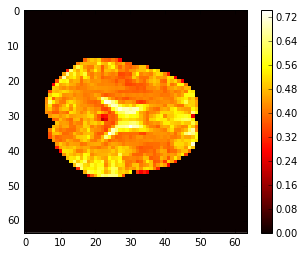

In [11]:
visu.mat(mean_volume[0,0,:,:,17])

In [33]:
model.get_weights()[-2]

array([[[[[ -6.38419464e-02,   6.02202937e-02,   4.53669056e-02],
          [ -2.35968363e-02,  -1.41380718e-02,  -6.75514191e-02],
          [ -7.16827586e-02,  -3.95688228e-02,  -9.17448401e-02]],

         [[ -1.17125846e-02,   6.69423789e-02,  -4.02696244e-02],
          [  3.70602906e-02,  -4.54180837e-02,   5.14108203e-02],
          [  2.33163033e-02,   9.07840058e-02,  -5.85252345e-02]],

         [[  8.82702768e-02,  -3.10338810e-02,   1.79753639e-03],
          [ -5.39547019e-02,   1.24552683e-03,   5.64154685e-02],
          [  5.46083786e-02,  -3.00404150e-02,  -9.41223744e-03]]],


        [[[ -3.36762369e-02,   8.71244967e-02,  -7.86893293e-02],
          [  2.76413243e-02,   1.97357070e-02,   4.43743914e-02],
          [  2.16294732e-02,   8.59050453e-03,  -5.91483228e-02]],

         [[ -7.19571393e-03,   2.55904123e-02,   7.32431710e-02],
          [ -3.94744016e-02,   1.06470250e-01,  -7.51489252e-02],
          [ -1.45515716e-02,  -4.56741042e-02,   1.15684373e-02]],

In [8]:
show_report(np.vstack(ref_vals),np.vstack(pred_vals),mask,frames=np.arange(0,10),mask_b=mask_b)
print fd[0:10]

ValueError: need at least one array to concatenate

Using Theano backend.
Using gpu device 0: GeForce GTX 550 Ti (CNMeM is disabled, cuDNN not available)

--------------------kfold 1--------------------
(None, 1, 64, 64, 33)
Train on 108 samples, validate on 27 samples
Epoch 1/3
108/108 [==============================] - 6s - loss: 0.1792 - val_loss: 0.1212
Epoch 2/3
108/108 [==============================] - 6s - loss: 0.1169 - val_loss: 0.1247
Epoch 3/3
108/108 [==============================] - 6s - loss: 0.1175 - val_loss: 0.1303
Average R2:  -7.41905327378


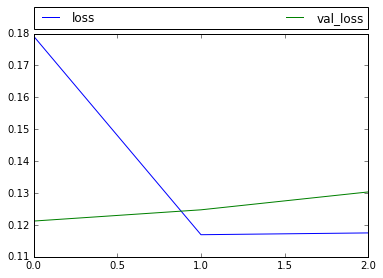

In [7]:
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.layers.convolutional import Convolution3D
from keras.layers.convolutional import UpSampling3D
from keras.engine.topology import Merge
from keras.layers.core import RepeatVector,Reshape
from keras.regularizers import l2, activity_l2
#from keras.layers.core import SpatialDropout3D


def build_model(output_size,kdim=[3,3,3],motion_out_size=32):
    
        
    # convolution branch
    model_conv = Sequential()
    #model.add(UpSampling3D(size=(2, 2, 2), dim_ordering='default',input_shape=(1, output_size[0], output_size[1], output_size[2])))
    model_conv.add(Convolution3D(5,kernel_dim1=kdim[0],kernel_dim2=kdim[1],kernel_dim3=kdim[2], input_shape=(6, output_size[0], output_size[1], output_size[2]),border_mode='same',W_regularizer=None,init='uniform'))
    model_conv.add(Activation('tanh'))
    #model_conv.add(SpatialDropout3D(0.5))
    
    #model_conv.add(Convolution3D(32,kernel_dim1=kdim[0],kernel_dim2=kdim[1],kernel_dim3=kdim[2],border_mode='same',W_regularizer=None,init='uniform'))
    #model_conv.add(Activation('tanh'))
    #model_conv.add(SpatialDropout3D(0.5))
    
    #model_conv.add(Convolution3D(32,kernel_dim1=kdim[0],kernel_dim2=kdim[1],kernel_dim3=kdim[2],border_mode='same',init='uniform'))
    #model_conv.add(Activation('tanh'))
    #model_conv.add(SpatialDropout3D(0.5))

    
    model_conv.add(Convolution3D(1,kernel_dim1=kdim[0],kernel_dim2=kdim[1],kernel_dim3=kdim[2],border_mode='same',init='uniform'))
    #model_conv.add(Activation('linear'))
    
    print model_conv.output_shape
    
    sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=False)
    model_conv.compile(loss='mean_squared_error', optimizer=sgd)
    #model_conv.compile(loss=mean_squared_error_masked, optimizer=sgd) #compute the loss inside the brain only
    return model_conv


nb_epoch = 3
validation_split = 0.2

# put the outside of the brain to zero
vol[~mask_b]=0


ts = vol[mask].T
kf = KFold(n=ts.shape[0], n_folds=10, shuffle=False,random_state=None)

pred_vals = []
ref_vals = []
k=1
for train, test in kf:
    
    ssx = MinMaxScaler(feature_range=(-1,1))
    ssy = MinMaxScaler(feature_range=(-1,1))
    ssvol = MinMaxScaler(feature_range=(0,1))
    
    #print train
    print ('-'*20)+'kfold '+ str(k)+('-'*20)
    k+=1
     # Train
    lreg_d = LinearRegression(fit_intercept=True,normalize=False)
    lreg_d.fit(Xdrift[train,:],ts[train,:])
    new_ts = ts-lreg_d.predict(Xdrift)
    
    lreg_md = LinearRegression(fit_intercept=True,normalize=False)
    lreg_md.fit(Xdrift[train,:],Xmotion[train,:])
    new_Xmotion = Xmotion - lreg_md.predict(Xdrift)
                     
    mean_volume = ssvol.fit_transform(lreg_d.intercept_.reshape(-1, 1))
    mean_volume = mean_volume.reshape((vol[...,0].shape))[np.newaxis,np.newaxis,...]
    y_ = ssy.fit_transform(new_ts[train,:]).reshape((len(train),vol.shape[0],vol.shape[1],vol.shape[2]))[:,np.newaxis,...]
    
    # Learn the regression parameters to predict time series
    model = build_model(vol.shape[:3])
    
    #model.lr=10
    #model.momentum=0.5
    x_augm,y_augm = np.concatenate((mean_volume,)* len(train), axis=0)*ssx.fit_transform(new_Xmotion[train,:])[:,:,np.newaxis,np.newaxis,np.newaxis],y_.copy()
    #x_augm,y_augm = data_augm(ssx.fit_transform(new_Xmotion[train,:]),np.concatenate((mean_volume,)* len(train), axis=0),y_)
    
    
    hist = model.fit(x_augm, y_augm,verbose=1, nb_epoch=nb_epoch, batch_size=1,validation_split=validation_split)
    
    plt.figure()
    if validation_split == 0.:
        plt.plot(range(nb_epoch),hist.history['loss'])
    else:
        plt.plot(range(nb_epoch),hist.history['loss'],range(nb_epoch),hist.history['val_loss'])
    plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    
    ## Test on independent data
    #X_test = ssx.transform(new_Xmotion[test,:])
    #mean_volumes_ = np.concatenate((mean_volume,)* len(test), axis=0)
    x_augm = np.concatenate((mean_volume,)* len(test), axis=0)*ssx.transform(new_Xmotion[test,:])[:,:,np.newaxis,np.newaxis,np.newaxis]
    test_data = model.predict(x_augm,batch_size=1)
    
    test_denorm = ssy.inverse_transform(test_data.reshape((len(test),vol.shape[0]*vol.shape[1]*vol.shape[2])))
    pred_vals.append(test_denorm)
    #.reshape((vol[...,test].shape))
    ref_vals.append(new_ts[test,:])
    
    break
    
print 'Average R2: ',getR2(np.vstack(ref_vals),np.vstack(pred_vals),mask=mask_b[mask]).mean()